In [2]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the CSV files
df_warehouses = pd.read_csv('./data/warehouse_locations.csv')
df_customers  = pd.read_csv('./data/customer_locations.csv')
df_supply     = pd.read_csv('./data/supply.csv')
df_driver     = pd.read_csv('./data/driver_locations.csv')

# Number of drivers
k = df_driver.shape[0]  # Adjust this value as needed

Visualization 

In [5]:
df_customers.columns = ['Customer', 'X', 'Y']
df_warehouses.columns = ['Warehouse', 'X', 'Y']
df_supply.columns = ['Warehouse', 'Supply']
df_driver.columns = ['Driver', 'X', 'Y']

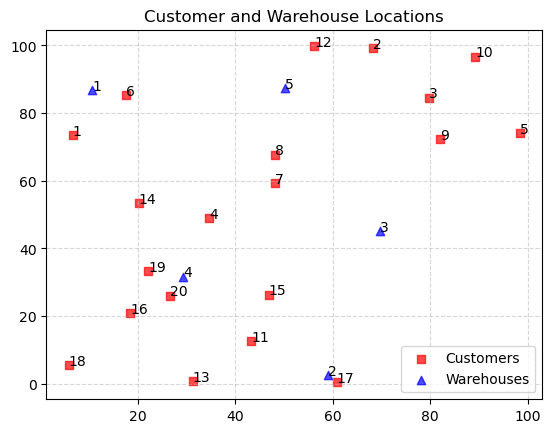

In [6]:
# Plot customer and warehouse locations
plt.scatter(df_customers['X'], df_customers['Y'],  marker='s', color = 'red', label = 'Customers', alpha=0.7)
plt.scatter(df_warehouses['X'], df_warehouses['Y'], marker='^', color = 'blue', label = 'Warehouses', alpha=0.7)
plt.title('Customer and Warehouse Locations')
plt.legend(loc = 'lower right')

# Label the warehouses and customers
for i in range(len(df_customers)):
    plt.text(df_customers['X'][i], df_customers['Y'][i], df_customers['Customer'][i]+1)

for i in range(len(df_warehouses)):
    plt.text(df_warehouses['X'][i], df_warehouses['Y'][i], df_warehouses['Warehouse'][i]+1)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [7]:
# Create dictionaries for warehouse and customer data
warehouses = {
    f'W{i+1:02}': {'coord': np.array([row['X'], row['Y']])}
    for i, row in df_warehouses.iterrows()
}

customers = {
    f'C{i+1:02}': {'coord': np.array([row['X'], row['Y']])}
    for i, row in df_customers.iterrows()
}

# Create a dictionary for supply data
supply = {
    f'W{i+1:02}': row['Supply'] for i, row in df_supply.iterrows()
}

drivers = {f'D{i+1:02}': {'coord': np.array([row['X'], row['Y']])} for i, row in df_driver.iterrows()}

# Problem 1

In [9]:
# Calculate Euclidean distances using np.linalg.norm
dij = {}
for i in warehouses:
    for j in customers:
        dij[i, j] = np.linalg.norm(warehouses[i]['coord'] - customers[j]['coord'])

In [10]:
# Initialize the Gurobi model
model = gp.Model("DeliveryOptimization")
model.setParam('OutputFlag', 0)  # Suppress output

# Decision variables
x = model.addVars(warehouses.keys(), customers.keys(), vtype=GRB.BINARY, name='x')

# Objective function: Minimize total distance
model.setObjective(gp.quicksum(dij[i, j] * x[i, j] for i in warehouses for j in customers), GRB.MINIMIZE)

# Constraint 1: Each customer receives at most one delivery
if k >= len(customers):
    # Enough drivers for all customers
    for j in customers:
        model.addConstr(gp.quicksum(x[i, j] for i in warehouses) == 1, name=f"Customer_{j}")
else:
    # Not enough drivers for all customers
    for j in customers:
        model.addConstr(gp.quicksum(x[i, j] for i in warehouses) <= 1, name=f"Customer_{j}")

# Constraint 2: Total number of deliveries equals the number of drivers or customers, whichever is smaller
model.addConstr(gp.quicksum(x[i, j] for i in warehouses for j in customers) == min(k, len(customers)), name="TotalDeliveries")

# Constraint 3: Warehouse supply constraintsd
for i in warehouses:
    model.addConstr(gp.quicksum(x[i, j] for j in customers) <= supply[i], name=f"Supply_{i}")

# Optimize the model
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-19


## Solution

In [12]:
# Check and extract the solution
if model.status == GRB.OPTIMAL:
    delivery_schedule = []
    count = 0
    total_distance = 0
    for i in warehouses:
        for j in customers:
            if x[i, j].X > 0.5:  # Since x[i, j] is binary
                distance = dij[i, j]
                total_distance += distance
                delivery_schedule.append({
                    'warehouse': i, 
                    'customer': j,
                    'distance': distance,
                    'start_coords': warehouses[i]['coord'], 
                    'end_coords': customers[j]['coord']
                })
    
    # Print the delivery schedule and total distance
    print("Optimal Delivery Route:")
    for delivery in delivery_schedule:
        count += 1
        print(f"Driver {count} delivers from Warehouse {delivery['warehouse']} to Customer {delivery['customer']} (Distance: {delivery['distance']:.1f} units)")
    print(f"Total Distance: {total_distance:.2f} units.")

else:
    print(f"No solution found. Status: {model.status}")

Optimal Delivery Route:
Driver 1 delivers from Warehouse W01 to Customer C01 (Distance: 13.8 units)
Driver 2 delivers from Warehouse W01 to Customer C06 (Distance: 7.1 units)
Driver 3 delivers from Warehouse W02 to Customer C17 (Distance: 2.8 units)
Driver 4 delivers from Warehouse W04 to Customer C19 (Distance: 7.4 units)
Driver 5 delivers from Warehouse W04 to Customer C20 (Distance: 6.2 units)
Driver 6 delivers from Warehouse W05 to Customer C12 (Distance: 13.6 units)
Total Distance: 50.91 units.


## Visualization

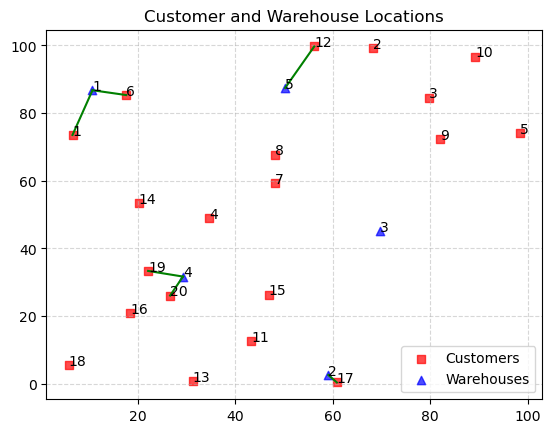

In [21]:
# Plot customer and warehouse locations
plt.scatter(df_customers['X'], df_customers['Y'], marker='s', color='red', label='Customers', alpha=0.7)
plt.scatter(df_warehouses['X'], df_warehouses['Y'], marker='^', color='blue', label='Warehouses', alpha=0.7)

# Title and Legend
plt.title('Customer and Warehouse Locations')
plt.legend(loc='lower right')

# Label the warehouses and customers
for i in range(len(df_customers)):
    plt.text(df_customers['X'][i], df_customers['Y'][i], str(df_customers['Customer'][i] + 1))

for i in range(len(df_warehouses)):
    plt.text(df_warehouses['X'][i], df_warehouses['Y'][i], str(df_warehouses['Warehouse'][i] + 1))

# Plot delivery routes
for idx, route in enumerate(delivery_schedule):
    plt.plot([route['start_coords'][0], route['end_coords'][0]],
             [route['start_coords'][1], route['end_coords'][1]],
             'g', label='Delivery Route' if idx == 0 else None)

# Grid and Save
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./plot/q1.png')  # Save before show
plt.show()

# Problem 2

In [24]:
nodes = {**warehouses, **customers}  # Combine warehouses and customers

dij = {}

for i in warehouses:
    for j in customers:
        dij[i,j] = np.linalg.norm(warehouses[i]['coord'] - customers[j]['coord'])

for i in customers:
    for j in customers:
        dij[i,j] = np.linalg.norm(customers[i]['coord'] - customers[j]['coord'])

In [26]:
# Create model
model = gp.Model("MinCostFlowDelivery")
model.setParam('OutputFlag', 0)  # Suppress output

# Decision variables: y[i,j] flow from node i to customer j
y = model.addVars(dij.keys(), name='y', lb=0, vtype=GRB.INTEGER)

# Objective function: Minimize total distance weighted by flow
model.setObjective(gp.quicksum(dij[i, j] * y[i, j] for i, j in dij.keys()), GRB.MINIMIZE)

# Warehouse supply constraints
for i in warehouses:
    model.addConstr(gp.quicksum(y[i, j] for j in customers) <= supply[i], name=f"Supply_{i}")

# Flow conservation at customer nodes
for j in customers:
    inflow = gp.quicksum(y[i, j] for i in nodes if i != j)
    outflow = gp.quicksum(y[j, k] for k in customers if k != j)
    model.addConstr(inflow - outflow == 1, name=f"FlowConservation_{j}")

# Constraint 2: Total number of deliveries equals the number of drivers or customers, whichever is smaller
# model.addConstr(gp.quicksum(y[i, j] for i in warehouses for j in customers) == min(k, len(customers)), name="TotalDeliveries")

# Optimize the model
model.optimize()

In [28]:
# dij['W02', 'C15']+dij['C15', 'C11']+dij['C11', 'C13']

In [32]:
# dij['W02', 'C15']+dij['W02', 'C11']+dij['W02', 'C13']

## Solution

In [35]:
# Check if optimal solution was found
if model.status == GRB.OPTIMAL:
    # print("\nOptimal solution found.\n")
    # Extract flows
    flows = {}
    for i in nodes:
        for j in customers:
            flow_value = y[i, j].X
            if flow_value > 0:  # Consider small threshold to filter out zero flows
                flows[(i, j)] = flow_value
                print(f"Flow from {i:00} to {j:00}: {flow_value:.2f} | Total {dij[i, j]:.1f} units.")
    print(f'The drivers travel {model.ObjVal:.2f} units')
else:
    print("No optimal solution found.")

Flow from W01 to C01: 1.00 | Total 13.8 units.
Flow from W01 to C06: 1.00 | Total 7.1 units.
Flow from W01 to C14: 1.00 | Total 34.7 units.
Flow from W02 to C11: 1.00 | Total 18.8 units.
Flow from W02 to C13: 1.00 | Total 27.9 units.
Flow from W02 to C15: 1.00 | Total 26.7 units.
Flow from W02 to C17: 1.00 | Total 2.8 units.
Flow from W03 to C05: 1.00 | Total 40.8 units.
Flow from W03 to C07: 1.00 | Total 25.9 units.
Flow from W03 to C09: 1.00 | Total 29.8 units.
Flow from W04 to C04: 1.00 | Total 18.1 units.
Flow from W04 to C16: 1.00 | Total 15.3 units.
Flow from W04 to C18: 1.00 | Total 35.2 units.
Flow from W04 to C19: 1.00 | Total 7.4 units.
Flow from W04 to C20: 1.00 | Total 6.2 units.
Flow from W05 to C02: 1.00 | Total 21.4 units.
Flow from W05 to C03: 1.00 | Total 29.7 units.
Flow from W05 to C08: 1.00 | Total 19.8 units.
Flow from W05 to C10: 1.00 | Total 40.1 units.
Flow from W05 to C12: 1.00 | Total 13.6 units.
The drivers travel 435.18 units


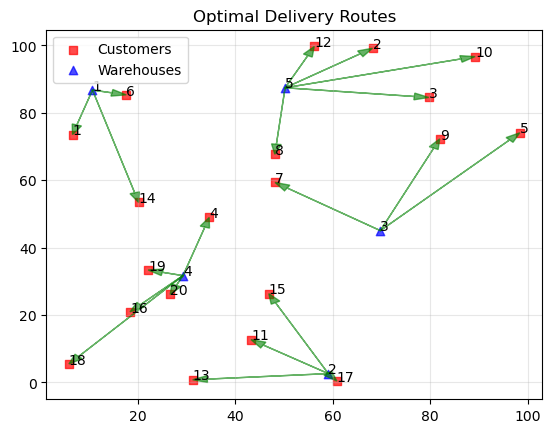

In [37]:
# Plot customer and warehouse locations
plt.scatter(df_customers['X'], df_customers['Y'], marker='s', color='red', label='Customers', alpha=0.7)
plt.scatter(df_warehouses['X'], df_warehouses['Y'], marker='^', color='blue', label='Warehouses', alpha=0.7)

# Title and Legend
plt.title('Customer and Warehouse Locations')
plt.legend(loc='lower right')

# Label the warehouses and customers
for i in range(len(df_customers)):
    plt.text(df_customers['X'][i], df_customers['Y'][i], str(df_customers['Customer'][i] + 1))

for i in range(len(df_warehouses)):
    plt.text(df_warehouses['X'][i], df_warehouses['Y'][i], str(df_warehouses['Warehouse'][i] + 1))


for (start, end), flow in flows.items():
    start_coord = warehouses[start]['coord'] if start in warehouses else customers[start]['coord']
    end_coord = customers[end]['coord']
    plt.arrow(start_coord[0], start_coord[1],
              end_coord[0] - start_coord[0], end_coord[1] - start_coord[1],
              color='green', alpha=0.6, head_width=2, length_includes_head=True)
    # Display flow value
    # mid_x = (start_coord[0] + end_coord[0]) / 2
    # mid_y = (start_coord[1] + end_coord[1]) / 2
    # plt.text(mid_x, mid_y, str(flow), color='green', fontsize=8)

# Add grid, legend, and title
plt.grid(alpha=0.3)
plt.legend()
plt.title('Optimal Delivery Routes')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
plt.savefig('q2.png')
plt.show()

# Problem 3

In [40]:
nodes = {**warehouses, **customers}  # Combine warehouses and customers

dij = {}

for i in warehouses:
    for j in customers:
        dij[i,j] = np.linalg.norm(warehouses[i]['coord'] - customers[j]['coord'])

for i in customers:
    for j in customers:
        dij[i,j] = np.linalg.norm(customers[i]['coord'] - customers[j]['coord'])

In [42]:
Q = 5

# Create model
model = gp.Model("VehicleRoutingProblem")
model.setParam('OutputFlag', 0)  # Suppress output

# Decision variables: z[i,j] == 1 if edge (i,j) is used
z = model.addVars(dij.keys(), vtype=GRB.BINARY, name='z')

# Decision variables: y[i,j] == 1 if edge (i,j) has product flowing through it
y = model.addVars(dij.keys(), name='y', lb=0, ub=Q,  vtype=GRB.INTEGER)

# Objective function: Minimize total distance
model.setObjective(gp.quicksum(dij[i, j] * z[i, j] for i, j in dij.keys()), GRB.MINIMIZE)

# Warehouse supply constraints
for i in warehouses:
    model.addConstr(gp.quicksum(y[i, j] for j in customers) <= supply[i], name=f"Supply_{i}")

# Adjust the flow conservation to ensure only necessary flow occurs
for j in customers:
    inflow = gp.quicksum(y[i, j] for i in nodes if i != j)  # Only consider flow from warehouses
    outflow = gp.quicksum(y[j, k] for k in customers if k != j)
    model.addConstr(inflow - outflow == 1, name=f"FlowConservation_{j}")

# Ensure that every customer is visited exactly once by a driver
for j in customers:
    model.addConstr(gp.quicksum(z[i, j] for i in nodes if i != j) == 1, name=f"VisitConstraint_{j}")

# Prevent drivers from traveling directly between customers unless necessary
for j in customers:
    model.addConstr(gp.quicksum(z[j, i] for i in customers if i != j) <= 1, name=f"CustomerConnection_{j}")

# Constraint 2: Total number of deliveries equals the number of drivers or customers, whichever is smaller
model.addConstr(gp.quicksum(z[i, j] for i in warehouses.keys() for j in customers.keys()) <= k, name="TotalDeliveries")

for i in nodes:
    for j in customers.keys():
        if i!=j:
            model.addConstr(z[i, j] <= y[i, j],  name=f"Link_z_y_Lower_{i}_{j}")
            model.addConstr(y[i, j] <= Q * z[i, j], name=f"Link_z_y_Upper_{i}_{j}")

# Optimize the model
model.optimize()

## Solution

In [45]:
def reconstruct_routes(z_vars, warehouses, customers):
    """
    Reconstruct routes based on z_vars, supporting multiple trips starting from the same warehouse and ensuring
    all customers are served.

    Parameters:
        z_vars (dict): Gurobi decision variables z[i,j].
        warehouses (dict): Warehouses with their IDs.
        customers (dict): Customers with their IDs.

    Returns:
        List of routes, each route is a list of node IDs.
    """
    routes = []
    # Create a dictionary mapping from i to list of j for edges used in the solution
    edge_dict = {i: [] for i in warehouses}  # Initialize with empty lists for each node

    # Populate edge dictionary with all used edges
    for (i, j), var in z_vars.items():
        if var.X > 0.5:
            edge_dict.setdefault(i, []).append(j)

    visited = set()  # Set to track visited customers to avoid revisiting

    # Traverse the paths starting from each warehouse
    for start in warehouses:
        # There might be multiple customers to start routes with
        for next_node in edge_dict[start]:
            if next_node not in visited:  # Start a new route if the customer hasn't been visited
                route = [start]
                current = next_node
                route.append(current)
                visited.add(current)
                # Continue to extend the route until there are no more unvisited nodes to visit
                while any(n for n in edge_dict.get(current, []) if n not in visited):
                    for potential_next in edge_dict[current]:
                        if potential_next not in visited:
                            current = potential_next
                            route.append(current)
                            visited.add(current)
                            break  # Exit the loop once the next step is decided
                routes.append(route)

    return routes

In [47]:
# Check if an optimal solution was found
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found.\n")

    # Reconstruct routes
    routes = reconstruct_routes(z, warehouses, customers)

    # Assign routes to drivers and calculate total distance per route
    for driver_id, route in enumerate(routes, start=1):
        route_distance = 0.0
        route_steps = []
        previous_node = None  # Track the previous node to avoid duplicates
    
        for idx in range(len(route) - 1):
            i = route[idx]
            j = route[idx + 1]
            if j != previous_node:
                distance = dij.get((i, j), 0)
                route_distance += distance
                start_label = f"{i} -> " if i in warehouses else ""
                end_label = f"{j}"
                route_steps.append(f"{start_label}{end_label}")
                previous_node = j
    
        # Create a route string with total distance
        route_str = " -> ".join(route_steps)
        print(f"Driver {driver_id}: {route_str} | Total Distance: {route_distance:.2f} units")
    # Optional: Detailed Delivery Information
    print("\nDetailed Delivery Information:")
    for driver_id, route in enumerate(routes, start=1):
        print(f"\nDriver {driver_id}:")
        route_distance = 0.0
        for idx in range(len(route)-1):
            i = route[idx]
            j = route[idx+1]
            distance = dij.get((i, j), 0)
            route_distance += distance
            if i in warehouses:
                start_label = f"Warehouse {i}"
            else:
                start_label = f"Customer {i}"
            end_label = f"Customer {j}"
            print(f"  {start_label} -> {end_label}: Distance = {distance:.2f} units")
        print(f"  **Total Distance for Driver {driver_id}: {route_distance:.2f} units**")

    # Total distance for all drivers

    print(f"\nTotal Distance Traveled by All Drivers: {model.ObjVal:.2f} units")

else:
    print("No optimal solution found.")

Optimal Solution Found.

Driver 1: W01 -> C06 -> C01 | Total Distance: 23.22 units
Driver 2: W02 -> C17 -> C15 -> C11 -> C13 | Total Distance: 63.31 units
Driver 3: W03 -> C09 -> C03 -> C10 -> C05 | Total Distance: 82.11 units
Driver 4: W04 -> C19 -> C20 -> C16 -> C18 | Total Distance: 45.56 units
Driver 5: W05 -> C08 -> C07 -> C04 -> C14 | Total Distance: 60.40 units
Driver 6: W05 -> C12 -> C02 | Total Distance: 25.61 units

Detailed Delivery Information:

Driver 1:
  Warehouse W01 -> Customer C06: Distance = 7.07 units
  Customer C06 -> Customer C01: Distance = 16.15 units
  **Total Distance for Driver 1: 23.22 units**

Driver 2:
  Warehouse W02 -> Customer C17: Distance = 2.82 units
  Customer C17 -> Customer C15: Distance = 29.46 units
  Customer C15 -> Customer C11: Distance = 14.12 units
  Customer C11 -> Customer C13: Distance = 16.89 units
  **Total Distance for Driver 2: 63.31 units**

Driver 3:
  Warehouse W03 -> Customer C09: Distance = 29.82 units
  Customer C09 -> Customer

## Visualization

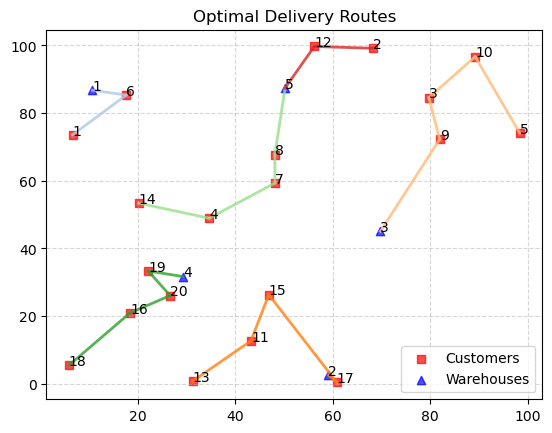

In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Scatter plot for customer and warehouse locations
plt.scatter(df_customers['X'], df_customers['Y'], marker="s", color = 'red', label = 'Customers', alpha=0.7)
plt.scatter(df_warehouses['X'], df_warehouses['Y'], marker="^", color = 'blue', label = 'Warehouses', alpha=0.7)
plt.legend(loc = 'lower right')

# Label the warehouses and customers
for i in range(len(df_customers)):
    plt.text(df_customers['X'][i], df_customers['Y'][i], str(df_customers['Customer'][i] + 1))

for i in range(len(df_warehouses)):
    plt.text(df_warehouses['X'][i], df_warehouses['Y'][i], str(df_warehouses['Warehouse'][i] + 1))

# Use a colormap for assigning a unique color to each warehouse
colors = cm.tab20(range(1, k+10))  # Use a colormap with 20 distinct colors
warehouse_colors = {}  # Dictionary to store the color for each warehouse

# Plot routes
for route_index, route in enumerate(routes):
    # Assign a unique color for each route starting from a warehouse
    warehouse_id = route[0]  # The first element is the warehouse ID
    if warehouse_id not in warehouse_colors:
        warehouse_colors[warehouse_id] = colors[route_index % len(colors)]
    if warehouse_id in warehouse_colors:
        warehouse_colors[warehouse_id] = colors[route_index % len(colors)]
        
        
    # Get the color for the current warehouse
    route_color = warehouse_colors[warehouse_id]
    
    # Plot the connections in the route
    for i in range(len(route) - 1):
        start_node = route[i]
        end_node = route[i + 1]
        plt.plot(
            [nodes[start_node]['coord'][0], nodes[end_node]['coord'][0]],
            [nodes[start_node]['coord'][1], nodes[end_node]['coord'][1]],
            color=route_color,
            linewidth=2,
            alpha=0.8
        )

# Add title and grid
plt.title('Optimal Delivery Routes')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('./plot/q3.png')  # Save before show
plt.show()

In [52]:
# import networkx as nx
# import matplotlib.pyplot as plt

# def visualize_routes(routes, nodes, dij):
#     G = nx.DiGraph()
#     pos = {node: nodes[node]['coord'] for node in nodes}

#     # Add edges based on z variables
#     for route in routes:
#         for idx in range(len(route)-1):
#             i = route[idx]
#             j = route[idx+1]
#             G.add_edge(i, j, weight=dij.get((i, j), 0))

#     edge_labels = {(i, j): f"{d:.2f}" for i, j, d in [(i, j, dij.get((i,j),0)) for i,j in G.edges()]}

#     plt.figure(figsize=(12, 8))
#     nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, arrows=True)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
#     plt.title("Optimal Delivery Routes")
#     plt.show()

# # Call the visualization function
# visualize_routes(routes, nodes, dij)

# Problem 4

In [55]:
def optimal_k(warehouses, customers, supply, dij, k, Q = 5):
    
    # Create model
    model = gp.Model("VehicleRoutingProblem")
    model.setParam('OutputFlag', 0)  # Suppress output
    
    # Decision variables: z[i,j] == 1 if edge (i,j) is used
    z = model.addVars(dij.keys(), vtype=GRB.BINARY, name='z')
    
    # Decision variables: y[i,j] == 1 if edge (i,j) has product flowing through it
    y = model.addVars(dij.keys(), name='y', lb=0, ub=Q,  vtype=GRB.INTEGER)
    
    # Objective function: Minimize total distance
    model.setObjective(gp.quicksum(dij[i, j] * z[i, j] for i, j in dij.keys()), GRB.MINIMIZE)
    
    # Warehouse supply constraints
    for i in warehouses:
        model.addConstr(gp.quicksum(y[i, j] for j in customers) <= supply[i], name=f"Supply_{i}")
    
    # Adjust the flow conservation to ensure only necessary flow occurs
    for j in customers:
        inflow = gp.quicksum(y[i, j] for i in nodes if i != j)  # Only consider flow from warehouses
        outflow = gp.quicksum(y[j, k] for k in customers if k != j)
        model.addConstr(inflow - outflow == 1, name=f"FlowConservation_{j}")
    
    # Ensure that every customer is visited exactly once by a driver
    for j in customers:
        model.addConstr(gp.quicksum(z[i, j] for i in nodes if i != j) == 1, name=f"VisitConstraint_{j}")
    
    # Prevent drivers from traveling directly between customers unless necessary
    for j in customers:
        model.addConstr(gp.quicksum(z[j, i] for i in customers if i != j) <= 1, name=f"CustomerConnection_{j}")
    
    # Constraint 2: Total number of deliveries equals the number of drivers or customers, whichever is smaller
    model.addConstr(gp.quicksum(z[i, j] for i in warehouses.keys() for j in customers.keys()) <= k, name="TotalDeliveries")
    
    for i in nodes:
        for j in customers.keys():
            if i!=j:
                model.addConstr(z[i, j] <= y[i, j],  name=f"Link_z_y_Lower_{i}_{j}")
                model.addConstr(y[i, j] <= Q * z[i, j], name=f"Link_z_y_Upper_{i}_{j}")
    
    # Optimize the model
    model.optimize()
    return model.objVal

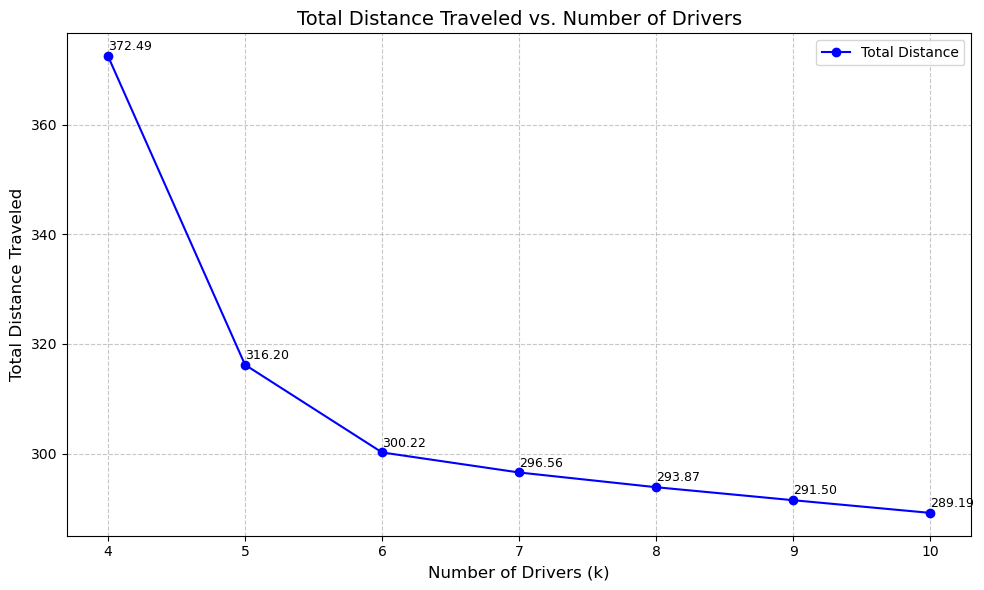

In [65]:
opk = {}

for k in range(4,11):
    opk[k] = optimal_k(warehouses, customers, supply, dij, k)

plt.figure(figsize=(10, 6))

# Create a line plot
plt.plot(opk.keys(), opk.values(), marker='o', linestyle='-', color='b', label='Total Distance')

# Annotate each data point with its value
for k, distance in opk.items():
    plt.text(k, distance + 0.5, f'{distance:.2f}', ha='left', va='bottom', fontsize=9, color='black')

# Add title and labels
plt.title('Total Distance Traveled vs. Number of Drivers', fontsize=14)
plt.xlabel('Number of Drivers (k)', fontsize=12)
plt.ylabel('Total Distance Traveled', fontsize=12)

# Customize ticks
plt.xticks(range(min(opk.keys()), max(opk.keys()) + 1))

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('./plot/q4.png')  # Save before show
plt.show()

# Problem 5

## Location Visualization 

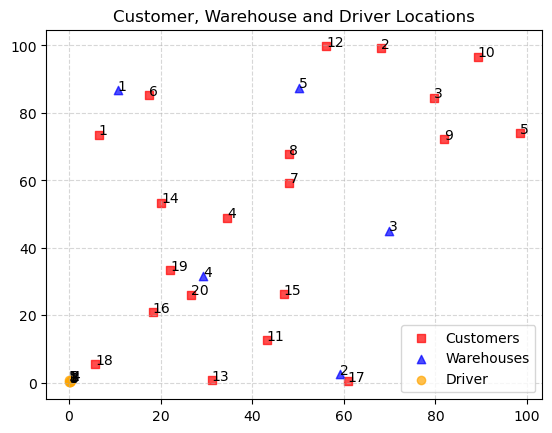

In [69]:
# Plot customer and warehouse locations
plt.scatter(df_customers['X'], df_customers['Y'], marker= 's',  color = 'red', label = 'Customers', alpha=0.7)
plt.scatter(df_warehouses['X'], df_warehouses['Y'],  marker="^",  color = 'blue', label = 'Warehouses', alpha=0.7)
plt.scatter(df_driver['X'], df_driver['Y'], marker= 'o',  color = 'orange', label = 'Driver', alpha=0.7)
plt.title('Customer, Warehouse and Driver Locations')
plt.legend(loc = 'lower right')

# Label the warehouses and customers
for i in range(len(df_customers)):
    plt.text(df_customers['X'][i], df_customers['Y'][i], df_customers['Customer'][i]+1)

for i in range(len(df_warehouses)):
    plt.text(df_warehouses['X'][i], df_warehouses['Y'][i],df_warehouses['Warehouse'][i]+1)

for i in range(len(df_driver)):
    plt.text(df_driver['X'][i], df_driver['Y'][i], df_driver['Driver'][i]+1)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Problem

In [122]:
# Combine all nodes: Drivers (D), Warehouses (W), Customers (N)
# nodes = {**drivers, **warehouses, **customers}
nodes = {**warehouses, **customers}

# Number of available drivers
k = len(drivers)  # In this case, k = 6

# Maximum number of customers per driver (vehicle capacity)
Q = 5

dij = {}

for i in drivers:
    for j in warehouses:
        dij[i,j] = np.linalg.norm(drivers[i]['coord'] - warehouses[j]['coord'])

for i in warehouses:
    for j in customers:
        dij[i,j] = np.linalg.norm(warehouses[i]['coord'] - customers[j]['coord'])

for i in customers:
    for j in customers:
        dij[i,j] = np.linalg.norm(customers[i]['coord'] - customers[j]['coord'])

In [132]:
# Create the model
model = gp.Model("delivery_routing")
model.setParam('OutputFlag', 0)  # Suppress Gurobi output

# Decision variables
y = model.addVars(dij.keys(), vtype=GRB.INTEGER, name="y", lb=0, ub=Q)  # Flow from node i to customer j
z = model.addVars(dij.keys(), vtype=GRB.BINARY, name="z")  # Binary variable for activated flow

# Objective function: minimize total distance based on z_ij 
model.setObjective(gp.quicksum(dij[i, j] * z[i, j] for (i, j) in dij), GRB.MINIMIZE)

# Decision variables: z[i,j] == 1 if edge (i,j) is used
z = model.addVars(dij.keys(), vtype=GRB.BINARY, name='z')

# Decision variables: y[i,j] == 1 if edge (i,j) has product flowing through it
y = model.addVars(dij.keys(), name='y', lb=0, ub=Q,  vtype=GRB.INTEGER)

# Objective function: Minimize total distance
model.setObjective(gp.quicksum(dij[i, j] * z[i, j] for i, j in dij.keys()), GRB.MINIMIZE)

# Warehouse supply constraints
for i in warehouses:
    model.addConstr(gp.quicksum(y[i, j] for j in customers) <= supply[i], name=f"Supply_{i}")

# Adjust the flow conservation to ensure only necessary flow occurs
for j in customers:
    inflow = gp.quicksum(y[i, j] for i in nodes if i != j)  # Only consider flow from warehouses
    outflow = gp.quicksum(y[j, k] for k in customers if k != j)
    model.addConstr(inflow - outflow == 1, name=f"FlowConservation_{j}")

# Ensure that every customer is visited exactly once by a driver
for j in customers:
    model.addConstr(gp.quicksum(z[i, j] for i in nodes if i != j) == 1, name=f"VisitConstraint_{j}")

# Prevent drivers from traveling directly between customers unless necessary
for j in customers:
    model.addConstr(gp.quicksum(z[j, i] for i in customers if i != j) <= 1, name=f"CustomerConnection_{j}")

# Constraint 2: Total number of deliveries equals the number of drivers or customers, whichever is smaller
model.addConstr(gp.quicksum(z[i, j] for i in warehouses.keys() for j in customers.keys()) <= k, name="TotalDeliveries")

for i in nodes:
    for j in customers.keys():
        if i!=j:
            model.addConstr(z[i, j] <= y[i, j],  name=f"Link_z_y_Lower_{i}_{j}")
            model.addConstr(y[i, j] <= Q * z[i, j], name=f"Link_z_y_Upper_{i}_{j}")

# 6. At most one driver is assigned to each driver location (home)
for d in drivers:
    model.addConstr(gp.quicksum(z[d, j] for j in warehouses if (d, j) in dij.keys()) <= 1, f"driver_location_constraint_{d}")

# 7. Driver-Warehouse Consistency Constraint: Number of drivers assigned to a warehouse equals number of deliveries from that warehouse
for w in warehouses:
    model.addConstr(gp.quicksum(z[d, w] for d in drivers if (d, w) in dij.keys()) == \
                    gp.quicksum(z[w, j] for j in customers if (w, j) in dij.keys()),
                    f"driver_warehouse_constraint_{w}")

model.optimize()

In [133]:
# ----------------------------
# 4. Route Reconstruction and Enhanced Output
# ----------------------------

def reconstruct_routes(z_vars, drivers, warehouses, customers):
    """
    Reconstruct routes based on z_vars.

    Parameters:
        z_vars (dict): Gurobi decision variables z[i,j].
        drivers (dict): Drivers with their IDs.
        warehouses (dict): Warehouses with their IDs.
        customers (dict): Customers with their IDs.

    Returns:
        Dictionary mapping driver IDs to their routes and total distance.
    """
    routes = {}
    # Create a dictionary mapping from i to j for edges used in the solution
    edge_dict = {}
    for (i, j), var in z_vars.items():
        if var.X > 0.5:
            edge_dict[i] = j

    # Traverse the paths starting from each driver's home
    for d in drivers:
        if d in edge_dict:
            route = [d]
            current = edge_dict[d]
            route.append(current)
            while current in edge_dict:
                next_node = edge_dict[current]
                if next_node == d:
                    break  # Prevent cycles
                route.append(next_node)
                current = next_node
                if len(route) > len(nodes):
                    print(f"Error: Potential loop detected in routes for driver {d}.")
                    break
            routes[d] = route

    # Calculate total distance per route
    routes_with_distance = {}
    for d, route in routes.items():
        total_distance = 0.0
        for idx in range(len(route)-1):
            i = route[idx]
            j = route[idx+1]
            distance = dij.get((i, j), 0)
            total_distance += distance
        routes_with_distance[d] = {'route': route, 'total_distance': total_distance}

    return routes_with_distance

In [134]:
# Check if an optimal solution was found
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found.\n")

    # Reconstruct routes
    routes = reconstruct_routes(z, drivers, warehouses, customers)

    # Print each driver's route with total distance
    for driver_id, info in routes.items():
        route = info['route']
        total_distance = info['total_distance']
        route_labels = []
        for node in route:
            if node in drivers:
                label = f"Home ({node})"
            elif node in warehouses:
                label = f"Warehouse ({node})"
            elif node in customers:
                label = f"Customer ({node})"
            else:
                label = f"Node ({node})"
            route_labels.append(label)
        route_str = " -> ".join(route_labels)
        print(f"{driver_id}: {route_str} | Total Distance: {total_distance:.2f} units")

    # Optional: Detailed Delivery Information with Distances
    print("\nDetailed Delivery Information:")
    for driver_id, info in routes.items():
        route = info['route']
        total_distance = info['total_distance']
        print(f"\n{driver_id}:")
        for idx in range(len(route)-1):
            i = route[idx]
            j = route[idx+1]
            distance = dij.get((i, j), 0)
            if i in drivers:
                start_label = f"Home ({i})"
            elif i in warehouses:
                start_label = f"Warehouse ({i})"
            elif i in customers:
                start_label = f"Customer ({i})"
            else:
                start_label = f"Node ({i})"
            if j in warehouses:
                end_label = f"Warehouse ({j})"
            elif j in customers:
                end_label = f"Customer ({j})"
            else:
                end_label = f"Node ({j})"
            print(f"  {start_label} -> {end_label}: Distance = {distance:.2f} units")
        print(f"  **Total Distance for {driver_id}: {total_distance:.2f} units**")

    # Total distance for all drivers
    total_distance_all = sum(info['total_distance'] for info in routes.values())
    print(f"\nTotal Distance Traveled by All Drivers: {total_distance_all:.2f} units")

else:
    print("No optimal solution found.")

Optimal Solution Found.

D02: Home (D02) -> Warehouse (W05) -> Customer (C12) -> Customer (C02) -> Customer (C10) -> Customer (C03) -> Customer (C05) | Total Distance: 183.63 units
D04: Home (D04) -> Warehouse (W04) -> Customer (C19) -> Customer (C20) -> Customer (C16) -> Customer (C18) -> Customer (C13) | Total Distance: 113.76 units
D05: Home (D05) -> Warehouse (W01) -> Customer (C06) -> Customer (C01) -> Customer (C14) -> Customer (C08) -> Customer (C09) | Total Distance: 199.64 units
D06: Home (D06) -> Warehouse (W03) -> Customer (C07) -> Customer (C04) -> Customer (C15) -> Customer (C11) -> Customer (C17) | Total Distance: 187.02 units

Detailed Delivery Information:

D02:
  Home (D02) -> Warehouse (W05): Distance = 99.97 units
  Warehouse (W05) -> Customer (C12): Distance = 13.63 units
  Customer (C12) -> Customer (C02): Distance = 11.98 units
  Customer (C02) -> Customer (C10): Distance = 21.22 units
  Customer (C10) -> Customer (C03): Distance = 15.41 units
  Customer (C03) -> 

## Visualization

C:\Users\utgoy\AppData\Local\Temp\ipykernel_31072\2373864518.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_colors)


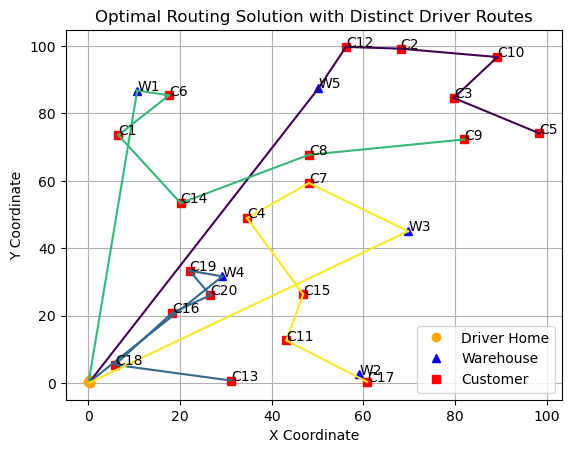

In [144]:
import matplotlib.pyplot as plt
import numpy as np

nodes = {**drivers, **warehouses, **customers}

# Define a function to generate distinct colors
def get_colors(num_colors):
    colors = plt.cm.get_cmap('viridis', num_colors)
    return [colors(i) for i in range(num_colors)]

# Initialize plot
fig, ax = plt.subplots()

for i in range(len(df_customers)):
    ax.text(df_customers['X'][i], df_customers['Y'][i], "C"+str(df_customers['Customer'][i] + 1))

for i in range(len(df_warehouses)):
    ax.text(df_warehouses['X'][i], df_warehouses['Y'][i], "W"+str(df_warehouses['Warehouse'][i] + 1))

# Plot all nodes with different markers/colors
for node, data in drivers.items():
    ax.plot(data['coord'][0], data['coord'][1], 'o', label='Driver Home' if node == list(drivers.keys())[0] else "", color='orange')

for node, data in warehouses.items():
    ax.plot(data['coord'][0], data['coord'][1], '^', label='Warehouse' if node == list(warehouses.keys())[0] else "", color='blue')

for node, data in customers.items():
    ax.plot(data['coord'][0], data['coord'][1], 's', label='Customer' if node == list(customers.keys())[0] else "", color='red')

# Check if the model was solved to optimality
if model.status == GRB.OPTIMAL:
    # Extract routes starting from drivers
    routes = {}
    for i in drivers.keys():
        for j in warehouses.keys():
            if z[i, j].X > 0.5:
                route = [i]
                current_node = j
                route.append(current_node)
                while any(z[current_node, k].X > 0.5 for k in nodes if (current_node, k) in z):
                    next_node = next(k for k in nodes if (current_node, k) in z and z[current_node, k].X > 0.5)
                    route.append(next_node)
                    current_node = next_node
                routes[i] = route
    
    # Get a list of distinct colors, one for each route
    num_routes = len(routes)
    route_colors = get_colors(num_routes)

    # Plot routes with different colors
    for route_idx, (driver, path) in enumerate(routes.items()):
        for start, end in zip(path[:-1], path[1:]):
            start_point = nodes[start]['coord']
            end_point = nodes[end]['coord']
            ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color=route_colors[route_idx], linestyle='-')

    # Enhance plot
    ax.legend()
    ax.grid(True)
    ax.set_title('Optimal Routing Solution with Distinct Driver Routes')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    plt.savefig('./plot/q5.png')  # Save before show
    plt.show()
else:
    print("No optimal solution found or the model is not solved yet.")